In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from joblib import dump

# Make sure output folders exist
os.makedirs("plots", exist_ok=True)
os.makedirs("models", exist_ok=True)
os.makedirs("reports", exist_ok=True)


In [2]:
# Prefer preprocessed dataset if available
data_path = "water_potability_preprocessed.csv" if os.path.exists("water_potability_preprocessed.csv") else "water_potability.csv"
df = pd.read_csv(data_path)

# Safety: check target column
if "Potability" not in df.columns:
    raise ValueError("Dataset must contain a 'Potability' column.")

# Handle missing values if any
if df.isnull().sum().sum() > 0:
    df = df.fillna(df.mean(numeric_only=True))

X = df.drop("Potability", axis=1)
y = df["Potability"].astype(int)

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

df.head()


,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,-6.043133e-16,0.259195,-0.139471,0.112415,9.613574e-01,1.708954,-1.180651,1.306149,-1.286298,0
1,-2.289339e+00,-2.036414,-0.385987,-0.307694,3.145987e-15,2.062575,0.270597,-0.638480,0.684218,0
2,6.928678e-01,0.847665,-0.240047,1.360594,3.145987e-15,-0.094032,0.781117,0.001509,-1.167365,0
3,8.409504e-01,0.547651,0.000493,0.592008,6.395190e-01,-0.778830,1.255134,2.152874,0.848412,0
4,1.368569e+00,-0.464429,-0.460249,-0.363698,-6.541765e-01,-0.343939,-0.824357,-2.181599,0.138786,0


In [3]:
models = {
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=2000, class_weight="balanced"))
    ]),
    "SVM (RBF)": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(kernel="rbf", probability=True, class_weight="balanced", random_state=42))
    ]),
    "KNN (k=7)": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", KNeighborsClassifier(n_neighbors=7))
    ]),
    "Random Forest": RandomForestClassifier(
        n_estimators=200, random_state=42, class_weight="balanced"
    ),
}


In [4]:
def get_proba(estimator, X_):
    if hasattr(estimator, "predict_proba"):
        return estimator.predict_proba(X_)[:, 1]
    if hasattr(estimator, "decision_function"):
        s = estimator.decision_function(X_)
        s_min, s_max = np.min(s), np.max(s)
        return (s - s_min) / (s_max - s_min + 1e-9)
    return estimator.predict(X_)


In [5]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []
best_name, best_score, best_estimator = None, -1, None
reports_md = ["# Week 2 – Model Evaluation\n"]

for name, est in models.items():
    cv_acc = cross_val_score(est, X, y, cv=cv, scoring="accuracy").mean()

    est.fit(X_train, y_train)
    y_pred = est.predict(X_test)
    y_proba = get_proba(est, X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    try:
        auc = roc_auc_score(y_test, y_proba)
    except:
        auc = float("nan")

    results.append({
        "Model": name,
        "CV_Accuracy": round(cv_acc, 4),
        "Test_Accuracy": round(acc, 4),
        "Precision": round(prec, 4),
        "Recall": round(rec, 4),
        "F1": round(f1, 4),
        "ROC_AUC": round(auc, 4) if not np.isnan(auc) else np.nan
    })

    # Save confusion matrix plot
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4.5, 4))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title(f"Confusion Matrix – {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig(f"plots/confusion_matrix_{name.replace(' ', '_').replace('(', '').replace(')', '')}.png")
    plt.close()

    if (auc if not np.isnan(auc) else acc) > best_score:
        best_score = auc if not np.isnan(auc) else acc
        best_name, best_estimator = name, est

print("Done training. Best model:", best_name)


Done training. Best model: Random Forest


In [6]:
df_res = pd.DataFrame(results).sort_values(by=["ROC_AUC", "Test_Accuracy"], ascending=False)
df_res


,Model,CV_Accuracy,Test_Accuracy,Precision,Recall,F1,ROC_AUC
3,Random Forest,0.6740,0.6646,0.6698,0.2773,0.3923,0.6576
1,SVM (RBF),0.6532,0.6220,0.5159,0.5078,0.5118,0.6444
2,KNN (k=7),0.6404,0.5899,0.4570,0.2695,0.3391,0.5995
0,Logistic Regression,0.5055,0.5259,0.4164,0.5352,0.4684,0.5480


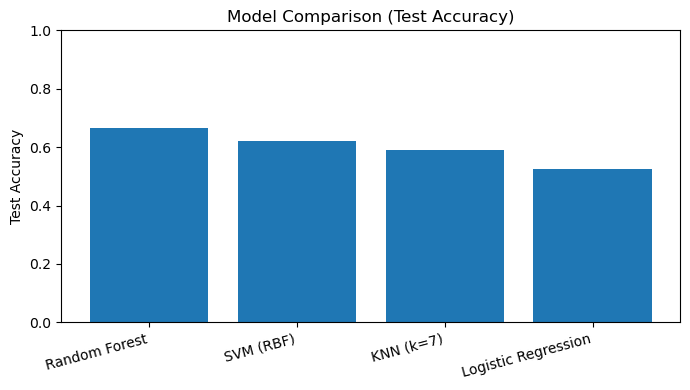

In [7]:
# Save best model
dump(best_estimator, "models/best_model.pkl")

# Save results table
df_res.to_csv("reports/results.csv", index=False)

# Bar plot of test accuracies
plt.figure(figsize=(7,4))
plt.bar(df_res["Model"], df_res["Test_Accuracy"])
plt.xticks(rotation=15, ha="right")
plt.ylim(0,1)
plt.ylabel("Test Accuracy")
plt.title("Model Comparison (Test Accuracy)")
plt.tight_layout()
plt.savefig("plots/model_comparison_accuracy.png")
plt.show()


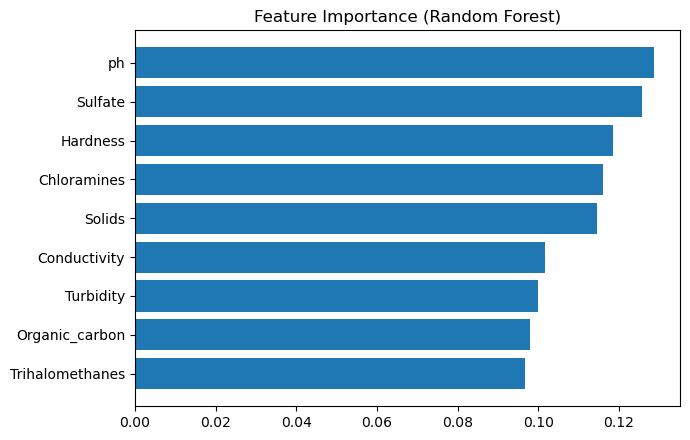

In [8]:
if best_name.startswith("Random Forest"):
    rf = best_estimator
    importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=True)
    plt.figure(figsize=(7,4.5))
    plt.barh(importances.index, importances.values)
    plt.title("Feature Importance (Random Forest)")
    plt.tight_layout()
    plt.savefig("plots/feature_importance_random_forest.png")
    plt.show()


In [9]:
from joblib import load

# Load your saved best model
best_model = load("models/best_model.pkl")

# Test it on some data
sample = X_test.iloc[0:5]   # first 5 rows from your test set
print("Predictions:", best_model.predict(sample))


Predictions: [0 0 0 0 0]


In [10]:
import pandas as pd

results = pd.read_csv("reports/results.csv")

# Get best by Test Accuracy
best = results.sort_values(by="Test_Accuracy", ascending=False).iloc[0]
print("Best Model:")
print(best)


Best Model:
Model            Random Forest
CV_Accuracy              0.674
Test_Accuracy           0.6646
Precision               0.6698
Recall                  0.2773
F1                      0.3923
ROC_AUC                 0.6576
Name: 0, dtype: object
